## VAE-TableGAN 생성 데이터 Evaluation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cuda


In [3]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_train.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_test.csv"
test_data = pd.read_csv(test_data_path)

## Load original data
fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-TableGAN/samples/loan_1_test1_50_generated_inputdim6.csv"
fake = pd.read_csv(fake_path, low_memory=False)

In [4]:
fake['loan_status'] = 1
fake.columns

Index(['last_fico_range_high', 'mo_sin_old_rev_tl_op', 'int_rate',
       'annual_inc', 'dti', 'installment', 'zip_code', 'revol_util',
       'fico_range_low', 'total_rev_hi_lim', 'revol_bal', 'bc_util',
       'avg_cur_bal', 'total_il_high_credit_limit', 'grade', 'total_pymnt',
       'total_pymnt_inv', 'loan_amnt', 'credit_history_years', 'term_months',
       'loan_status'],
      dtype='object')

In [7]:
for col in data.columns:
    print(f"{col} feature\n{data[col].unique()}")

last_fico_range_high feature
[744. 739. 614. 604. 654. 804. 824. 659. 559. 724. 769. 589. 499. 694.
 584. 719. 689. 669. 779. 684. 674. 749. 649. 664. 734. 639. 634. 594.
 619. 544. 699. 679. 759. 729. 784. 709. 549. 629. 704. 564. 579. 529.
 569. 714. 754. 599. 764. 539. 574. 534. 519. 524. 644. 814. 609. 794.
 789. 829. 774. 799. 514. 819. 834. 509. 624. 839. 554. 809. 504. 844.
 850.   0.]
mo_sin_old_rev_tl_op feature
[126.         151.         292.         206.         424.
 114.         308.         131.         275.         315.
 150.         365.         105.         333.         161.
 157.          95.         321.          81.         135.
 130.         117.         102.         223.         503.
 178.          56.         103.         199.         137.
 123.         138.          29.         189.         187.
  30.         118.         186.         259.         181.
  57.         180.62911797 101.         133.          61.
 215.         216.         159.         367.         

In [6]:
for col in fake.columns:
    print(f"{col} feature\n{fake[col].unique()}")

last_fico_range_high feature
[574. 569. 579. 564. 584. 559.]
mo_sin_old_rev_tl_op feature
[174.      161.      164.      179.      165.      176.      178.
 162.      175.      163.      170.      177.      169.      172.
 168.      167.      187.      160.      173.      159.      166.
 202.      183.      188.      180.      171.      182.      189.
 181.      185.      184.      180.62912 193.      186.      158.
 196.      197.      205.      204.      199.      206.      191.
 190.      201.      195.      157.      192.      194.      207.
 198.      212.      200.      203.      210.      208.      214.
 213.      209.      211.      217.      230.      219.      221.
 216.      218.      215.      223.      229.      220.      227.
 222.      226.      224.      240.      225.     ]
int_rate feature
[0.1565 0.1403 0.1393 0.1659 0.1398 0.1786 0.1399 0.1442 0.1793 0.1411
 0.1493 0.1408 0.1774 0.1449 0.1588 0.1541 0.143  0.1426 0.1446 0.1407
 0.1416 0.1655 0.1843 0.1913 0.1862 0.1

In [5]:
keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']

data_classification = data.copy()
test_classification = test_data.copy()
fake_classification = fake.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)
fake_classification = fake_classification.drop(columns = keep_features)

In [6]:
fake.columns

Index(['last_fico_range_high', 'mo_sin_old_rev_tl_op', 'int_rate',
       'annual_inc', 'dti', 'installment', 'zip_code', 'revol_util',
       'fico_range_low', 'total_rev_hi_lim', 'revol_bal', 'bc_util',
       'avg_cur_bal', 'total_il_high_credit_limit', 'grade', 'total_pymnt',
       'total_pymnt_inv', 'loan_amnt', 'credit_history_years', 'term_months',
       'loan_status'],
      dtype='object')

In [7]:
data_x = data_classification.drop(columns='loan_status')
data_y = data_classification[['loan_status']]

X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, train_size=0.8, test_size=0.2, random_state=42, stratify=data_y)

train_classification = pd.concat([X_train, y_train], axis=1)

In [8]:
from sklearn.utils import shuffle

train_data = pd.concat([train_classification, fake_classification])
train_data['loan_status'].value_counts()
train_data = shuffle(train_data, random_state=42)

In [9]:
train_data['loan_status'].value_counts()

loan_status
0    718935
1    714263
Name: count, dtype: int64

In [10]:
X_train = train_data.drop(columns='loan_status')
y_train = train_data[['loan_status']]

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification[['loan_status']]

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

model = XGBClassifier( 
    n_estimators=500,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.68511	validation_1-logloss:0.68429
[1]	validation_0-logloss:0.67725	validation_1-logloss:0.67756
[2]	validation_0-logloss:0.66953	validation_1-logloss:0.67095
[3]	validation_0-logloss:0.66197	validation_1-logloss:0.66448
[4]	validation_0-logloss:0.65455	validation_1-logloss:0.65813
[5]	validation_0-logloss:0.64727	validation_1-logloss:0.65190
[6]	validation_0-logloss:0.64013	validation_1-logloss:0.64579
[7]	validation_0-logloss:0.63313	validation_1-logloss:0.63979
[8]	validation_0-logloss:0.62625	validation_1-logloss:0.63390
[9]	validation_0-logloss:0.61950	validation_1-logloss:0.62812
[10]	validation_0-logloss:0.61288	validation_1-logloss:0.62245
[11]	validation_0-logloss:0.60637	validation_1-logloss:0.61688
[12]	validation_0-logloss:0.59999	validation_1-logloss:0.61141
[13]	validation_0-logloss:0.59371	validation_1-logloss:0.60604
[14]	validation_0-logloss:0.58755	validation_1-logloss:0.60077
[15]	validation_0-logloss:0.58150	validation_1-logloss:0.59559
[1

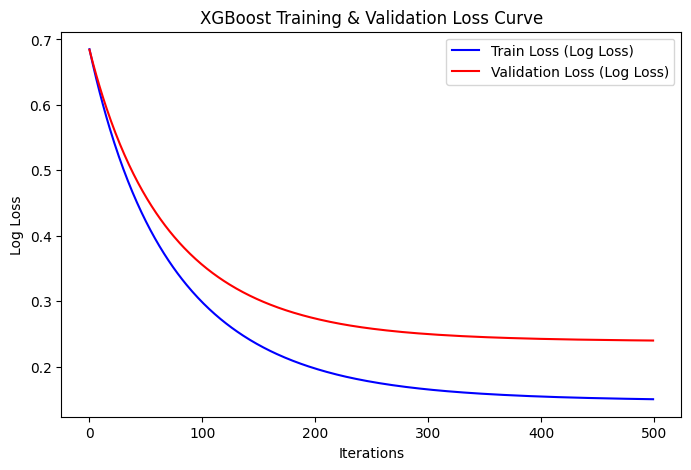

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94    599114
           1       0.73      0.76      0.74    145192

    accuracy                           0.90    744306
   macro avg       0.83      0.84      0.84    744306
weighted avg       0.90      0.90      0.90    744306



In [12]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [13]:
from sklearn.metrics import confusion_matrix
# confusion matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 행: 실제값 (y_test), 열: 예측값 (y_pred)
# [[TP, FP],
#  [FN, TN]]
TN, FP, FN, TP= cm.ravel()

print("✅ Confusion Matrix")
print(cm)
print(f"\nTrue Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

✅ Confusion Matrix
[[557508  41606]
 [ 35442 109750]]

True Positives (TP): 109750
False Positives (FP): 41606
True Negatives (TN): 557508
False Negatives (FN): 35442


## VAE-TableGAN 생성 데이터 Portfolio

In [14]:
summary_with_sharpe = []

def linear_portfolio(top_10_indices):
    selected = test_data.loc[top_10_indices.index].copy()
    returns = (selected['total_pymnt_inv'] - selected['loan_amnt']) / selected['loan_amnt']
    
    avg_return = returns.mean()
    std_return = returns.std()
    sharpe_ratio = avg_return / std_return if std_return != 0 else np.nan

    summary_with_sharpe.append({
        'Average Return': avg_return * 100,
        'Std Dev': std_return,
        'Sharpe Ratio': sharpe_ratio
    }) 

In [15]:
drop2 = ['loan_status', 'return']

scaler = StandardScaler()
reg = LinearRegression()

fully_paid_indices = (y_pred == 0)
test_regression = test_data[fully_paid_indices]
test_regression['return'] = (test_regression['total_pymnt_inv'] - test_regression['loan_amnt'])/test_regression['loan_amnt']

train_regression = data.copy()

train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['loan_amnt'])/train_regression['loan_amnt']

drop_features = ['loan_status', 'total_pymnt_inv', 'total_pymnt', 'grade', 'term_months']
train_regression = train_regression.drop(columns=drop_features)
test_regression = test_regression.drop(columns=drop_features)

fake_regression = fake.copy()

fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['loan_amnt'])/fake_regression['loan_amnt']
fake_regression = fake_regression.drop(columns=drop_features)

train_total = pd.concat([train_regression, fake_regression])

data_x = train_total.drop(columns='return')
data_y = train_total[['return']]

test_x = test_regression.drop(columns = 'return')
test_y = test_regression[['return']]

data_x_scaled = scaler.fit_transform(data_x)

X_train = data_x_scaled
y_train = data_y

test_x_scaled = scaler.transform(test_x)

reg.fit(X_train, y_train)

#print(reg.coef_)
y_pred = reg.predict(test_x_scaled)

print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
print("R²:", r2_score(test_y, y_pred))

test_regression['predicted_return'] = reg.predict(test_x_scaled)
top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

linear_portfolio(top_10_percent)

RMSE: 0.2395138726491106
R²: -0.5996495207993986


In [16]:
returns_with_sharpe_df = pd.DataFrame(summary_with_sharpe)

returns_with_sharpe_df.head()

,Average Return,Std Dev,Sharpe Ratio
0,13.374194,0.100629,1.329057


## Analysis between Original and VAE-TableGAN Samples

In [14]:
label1_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_train_label_1.csv"
label1_data = pd.read_csv(label1_data_path, low_memory=False)

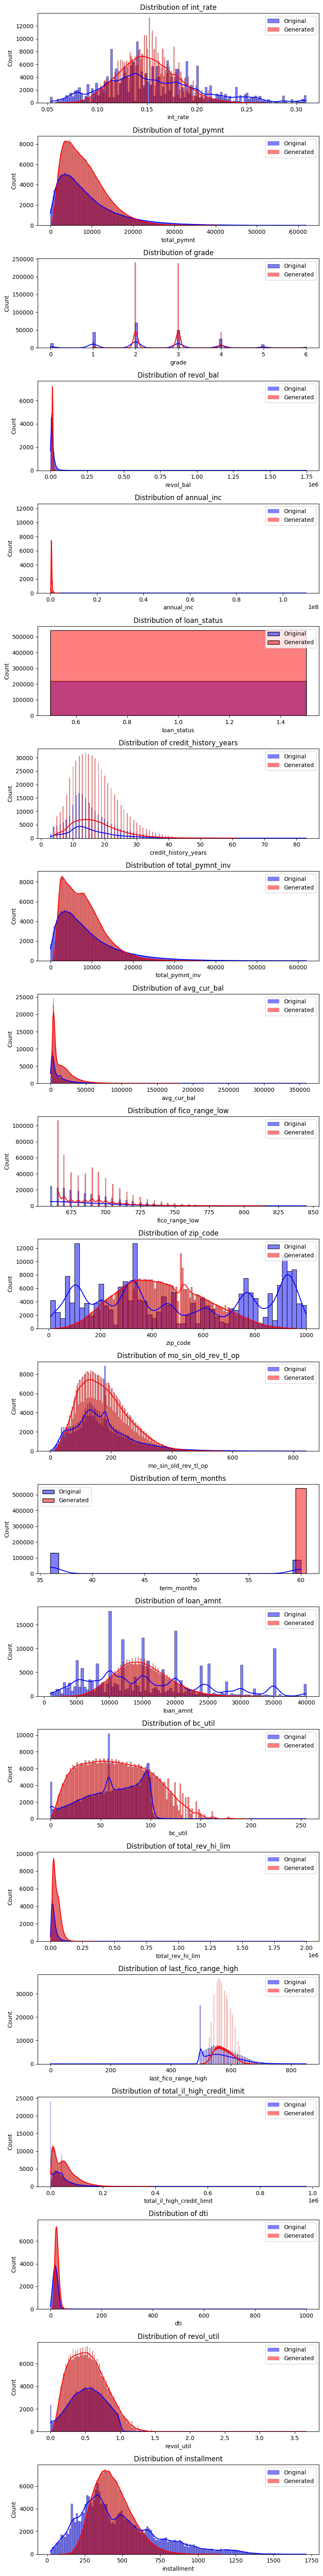

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 원본 데이터와 TableGAN 생성 데이터 불러오기
# 원본 데이터: original_df
# TableGAN이 생성한 데이터: generated_df

# 공통 feature 선택 (혹시 컬럼이 다를 수도 있으니)
common_features = list(set(data.columns) & set(fake.columns))
original_df = label1_data[common_features]
generated_df = fake[common_features]

# ------------------------------
# 1️⃣ 히스토그램 비교 (각 feature 분포)
# ------------------------------
num_features = len(common_features)
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(8, num_features * 3))

for i, feature in enumerate(common_features):
    sns.histplot(original_df[feature], color='blue', label='Original', kde=True, ax=axes[i], alpha=0.5)
    sns.histplot(generated_df[feature], color='red', label='Generated', kde=True, ax=axes[i], alpha=0.5)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].legend()

plt.tight_layout()
plt.show()